Author: Falak Shah, Infocusp Innovations Private Limited

# Hands on Diffusion model

[Diffusion models](https://arxiv.org/pdf/2006.11239.pdf) are a family of models that have shown amazing capability of generating photorealistic images with/ without text prompt. They have two flows as shown in the figure below -
1. Deterministic forward flow (from image to noise) and
2. Generative reverse flow (recreating image from noise).

Diffusion models get their name from the forward flow where they follow a markov chain of diffusion steps, each of which adds a small amount of random noise to the data. Then they learn the model to reverse the diffusion process and construct desired data samples from noise.

<figure>
<p style="text-align:center;"  align = "center"><img src="https://developer-blogs.nvidia.com/wp-content/uploads/2022/04/Fixed_Forward_Diffusion_Process.png" alt="Trulli" style="width:100%"  align = "center"></p>
<figcaption align = "center">Forward and reverse process <a href="https://developer.nvidia.com/blog/improving-diffusion-models-as-an-alternative-to-gans-part-1/">Ref: Nvidia blog</a> </figcaption>
</figure>



Since they map noise to data, these models can be said to be capable of learning the distributions that generate data of any particular domain.

This notebook showcases a minimal example of the forward diffusion process and its reverse mapping using a dense network. It is meant to give the reader side by side code snippets to match the equations in the paper and visual examples of the complete process.

### Imports and utility functions
"""

8000 samples of 2 dimensions in training data


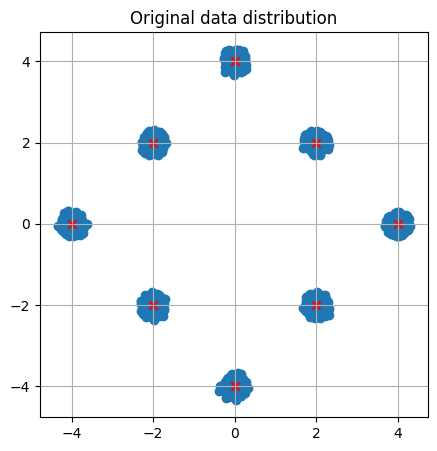

In [ ]:


#@title
! pip install celluloid
import math
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera
import functools
import sklearn.datasets
# For plotting
from IPython.display import HTML
from base64 import b64encode

#@title
# Utility function for displaying video inline in colab

def show_video(vname):
  mp4 = open(vname,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

def save_animation(vname, interval=30):
  anim = camera.animate(blit=True, interval=interval)
  anim.save(vname)

# Utility function for random noise
def noise_like(shape):
  return tf.random.normal(shape=shape, dtype=tf.float32)







In [ ]:
"""## Data distribution

Images can be thought of as points sampled from $height \times width$ dimensional space.

Consider an image of dimension $height \times width$. Then the total number of pixels are $height \times width$. Each pixel has a value ranging from 0 to 255.
Now, consider a vector space, where we flatten this image and represent the intensity of each pixel along one dimension of the vector space. For example, an image with $height = 2$ and $ width =3$ (2px x 3px image) becomes a single vector of length 6 where each component of this vector will have a value between 0 to 255.

So, in this image vector space, there are small clusters of valid (photorealistic) images sparsely distributed over the space. Rest of the vector space is made up of invalid (not real looking) images.

For the example in this notebook, we consider a **hypothetical** simplified version of the above representation. We consider images made of just 2 pixels, each of which can have values between [-5, 5]. This is to allow visualization of each dimension of the data as it moves through the forward and reverse process (and additionally faster training 😅).

The same code can be extended to the original image dimensions with just updated data dimensions.
"""

# Generate original points which are around [0.5, 0.5] in all quadrants and
# 4 corners ([0,1], [1,0], [0,-1], [-1, 0])
# Some region around these points indicates valid images region (true data distribution)

num_samples_per_center = 1000
stddev = 0.1
mean = 0

centers = tf.constant([[0,1], [1,0], [0,-1], [-1, 0],
                    [0.5, 0.5], [0.5, -0.5], [-0.5, -0.5],
                    [-0.5,0.5]]) * 4


all_data = []
# Data for all clusters
for idx in range(centers.shape[0]):
  center_data = tf.random.normal(shape=(num_samples_per_center, 2), stddev=stddev, mean=mean + centers[idx,:], dtype=tf.float32)
  all_data.append(center_data)

# X,_ = sklearn.datasets.make_moons(8000)
train_data_tf = tf.concat(all_data, axis=0)
print(f'{train_data_tf.shape[0]} samples of {train_data_tf.shape[1]} dimensions in training data')

"""The x's  in the plot below can be thought of as valid images in 2d space with the rest of the white region representing the rest of the invalid images. The blue clusters around the x's are also valid images (corresponding to minor pixel perturbations in original images)."""

#@title
# Visualize the data
plt.figure(figsize=[5,5])
plt.scatter(train_data_tf[:,0], train_data_tf[:,1])
for center in centers.numpy():
  # print(center[0], center[1])
  plt.scatter([center[0]], [center[1]], marker='x', color='r')
plt.title('Original data distribution')
plt.grid()

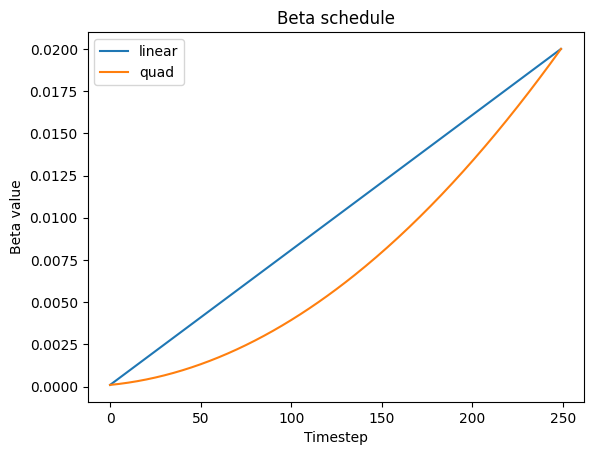

In [ ]:
"""## Beta schedule

Now that we have the original (non noisy) data, let's start now with the actual diffusion implementation. The first thing is to add noise to the input images following a fixed variance schedule (also known as beta schedule). The original paper uses a linear schedule. And 1000 timesteps to move forward and back. We use smaller number of timesteps (250) as the data is simpler in our case.
"""

num_diffusion_timesteps=250
beta_start=0.0001
beta_end=0.02
schedule_type='linear'

def get_beta_schedule(schedule_type, beta_start, beta_end, num_diffusion_timesteps):
  if schedule_type == 'quadratic':
    betas = np.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps, dtype=np.float32) ** 2
  elif schedule_type == 'linear':
    betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float32)
  return betas

betas_linear = get_beta_schedule('linear', beta_start, beta_end, num_diffusion_timesteps)
betas_quad = get_beta_schedule('quadratic', beta_start, beta_end, num_diffusion_timesteps)

"""### Visualize beta schedules

The below plot shows that the variance of noise is low at the start and increases as we move forward in time.
"""

#@title

plt.plot(betas_linear, label = 'linear')
plt.plot(betas_quad, label='quad')
plt.title('Beta schedule')
plt.ylabel('Beta value')
plt.xlabel('Timestep')
plt.legend()



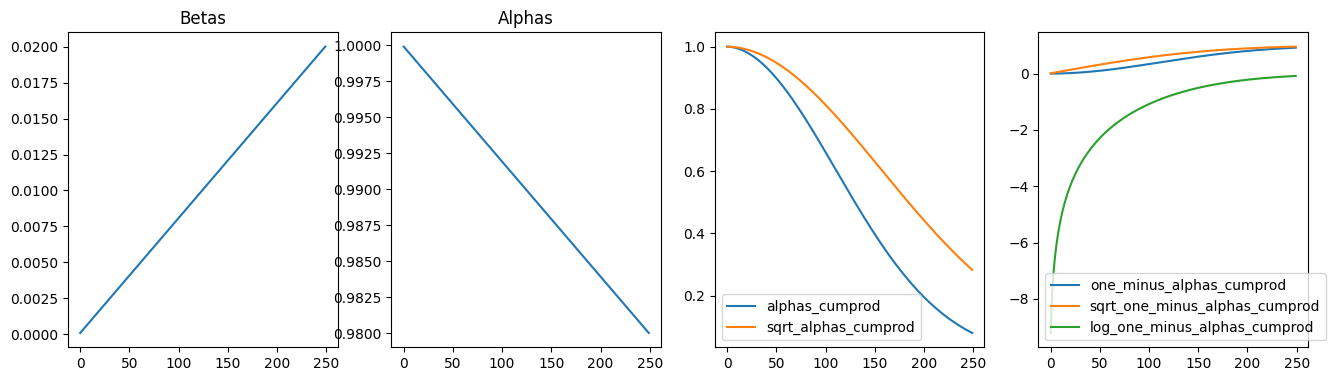

In [ ]:
"""### Beta derivatives

Next, let's compute all the derivatives from beta that are used repeatedly in the forward and reverse process of diffusion. Since the variance schedule ($\beta_t$) is fixed, the derivatives of $\beta_t$ are also fixed. We precompute these to save time/ compute.

We'll see the use cases of these variables in the respective sections below.
"""

class BetaDerivatives():
  def __init__(self, betas, dtype=tf.float32):
    """Take in betas and pre-compute the dependent values to use in forward/ backward pass.

    Values are precomputed for all timesteps so that they can be used as and
    when required.
    """
    self.np_betas = betas
    timesteps, = betas.shape
    self.num_timesteps = int(timesteps)

    self.betas = tf.constant(betas, dtype=dtype)
    self.alphas = tf.subtract(1., betas)
    self.alphas_cumprod = tf.math.cumprod(self.alphas, axis=0)
    self.alphas_cumprod_prev = tf.concat([tf.constant([1.0]), self.alphas_cumprod[:-1]], axis=0)

    # calculations required for diffusion q(x_t | x_{t-1}) and others
    self.sqrt_alphas_cumprod = tf.math.sqrt(self.alphas_cumprod)
    self.sqrt_one_minus_alphas_cumprod = tf.math.sqrt(1. - self.alphas_cumprod)
    self.log_one_minus_alphas_cumprod = tf.math.log(1. - self.alphas_cumprod)




  def _gather(self, a, t):
    """
    Utility function to extract some coefficients at specified timesteps,
    then reshape to [batch_size, 1] for broadcasting.
    """
    return tf.reshape(tf.gather(a, t), [-1, 1])

gdb = BetaDerivatives(betas_linear)

"""### Visualize beta derivatives over time"""

#@title
# Visualizing betas and other variables
plt.figure(figsize=(16, 9))

plt.subplot(2,4,1)
plt.plot(gdb.betas)
plt.title('Betas')
plt.subplot(2,4,2)
plt.plot(gdb.alphas)
plt.title('Alphas')

plt.subplot(2,4,3)
plt.plot(gdb.alphas_cumprod, label='alphas_cumprod')
plt.plot(gdb.sqrt_alphas_cumprod, label='sqrt_alphas_cumprod')
plt.legend();
plt.subplot(2,4,4)
plt.plot(1-gdb.alphas_cumprod, label='one_minus_alphas_cumprod')
plt.plot(gdb.sqrt_one_minus_alphas_cumprod, label='sqrt_one_minus_alphas_cumprod')
plt.plot(gdb.log_one_minus_alphas_cumprod, label='log_one_minus_alphas_cumprod')
plt.legend();



In [ ]:
"""## Forward pass of diffusion model

In the forward pass, the diffused input at timestep t can be computed directly using the closed form equation (For derivation of how we arrive at this, refer to the paper).

$q(x_t| x_0) = N(\sqrt{\bar{\alpha_t}}x_o, 1-\bar{\alpha_t}I)$

This is done in the q_sample function below.
"""

class DiffusionForward(BetaDerivatives):
  """
  Forward pass of the diffusion model.
  """

  def __init__(self, betas):
    super().__init__(betas)


  def q_sample(self, x_start, t, noise=None):
    """
    Forward pass - sample of diffused data at time t.
    """
    if noise is None:
      noise = tf.random.normal(shape=x_start.shape)
    p1 = self._gather(self.sqrt_alphas_cumprod, t) * x_start
    p2 = self._gather(self.sqrt_one_minus_alphas_cumprod, t) * noise
    return (p1 + p2)

diff_forward = DiffusionForward(betas_linear)

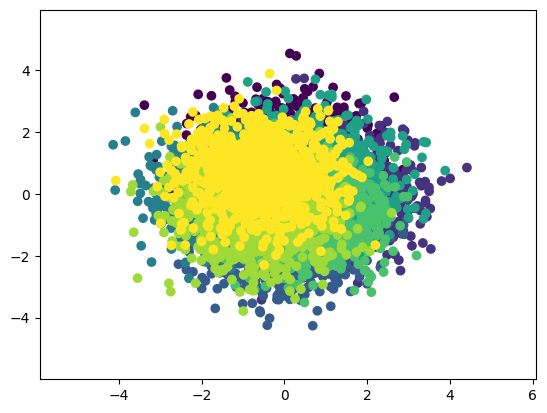

In [ ]:


"""### Visualize the forward diffusion of the entire data over time

We start with original data distribution and move it through the forward diffusion process 10 steps at a time. We can see that the original data distribution information is lost till it resembles gaussian after num_diffusion_steps.

Also, the slow perturbations at the start and large ones towards the end as per the beta schedule are evident from the video.
"""

#@title

camera = Camera(plt.figure())

x0 = train_data_tf[:]
for timestep in range(0, num_diffusion_timesteps, 10):
  tstep = tf.repeat(tf.constant(timestep), (x0.shape[0]))
  shifted = diff_forward.q_sample(x0, tstep)
  plt.scatter(shifted[:,0], shifted[:,1], c=np.arange(x0.shape[0])//num_samples_per_center)
  # plt.legend(f'Time step: {timestep}')
  camera.snap()

save_animation('scatter.mp4', 300)

show_video('scatter.mp4')



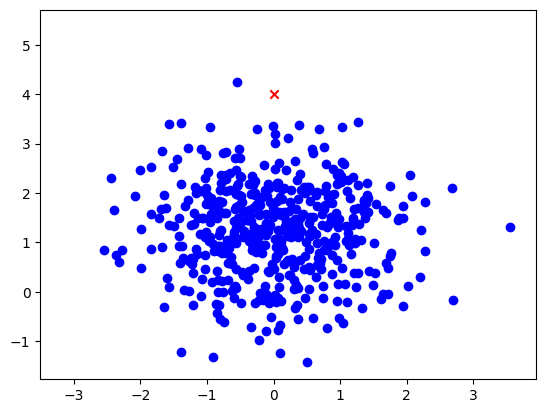

In [ ]:
"""### Visualize the forward pass of single point

We perform the forward diffusion of a single point over time. At every timestep, we generate 500 possible diffused samples of the same input point. We observe the distribution of these points over time.

These too are closer to the original point at the start and move towards gaussian as the forward process reaches num_timesteps same as the example above.
"""

#@title
camera = Camera(plt.figure())

x0 = tf.repeat(tf.constant([[0.0,4.0]]), (500), axis=0)
for timestep in range(0, num_diffusion_timesteps, 10):
  tstep = tf.repeat(tf.constant(timestep), (500))
  shifted = diff_forward.q_sample(x0, tstep)
  plt.scatter(shifted[:,0], shifted[:,1], c='b')
  plt.scatter(x0[0,0],x0[0,1], marker='x', c='r')
  camera.snap()

save_animation('pointshifting.mp4', 300)

show_video('pointshifting.mp4')



In [ ]:
"""## Model building

With the data taken care of, let's build a model that can fit the data. We use a DNN with few layers since we're just using data with 2 features that we wish to reconstruct. Would be replaced with unet with similar loss function for the case of image data.

The model takes in 2 inputs:
* Timestep embedding of $t$
* $x_t$

And predicts
* The noise $n$ that lead from $x_0$ to $x_t$

### Timestep embedding
"""
dim_time_embeeding=12

# We create a dimensional embedding of size (dim_time_embedding) for the timestep input to the model.
# Fixed embeddings similar to positional embeddings in transformer are used -
# could be replaced by trainable embeddings later

def get_timestep_embedding(timesteps, embedding_dim: int):
  half_dim = embedding_dim // 2
  emb = tf.math.log(10000.0) / (half_dim - 1)
  emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
  emb = tf.cast(timesteps, dtype=tf.float32)[:, None] * emb[None, :]
  emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
  if embedding_dim % 2 == 1:  # zero pad
    # emb = tf.concat([emb, tf.zeros([num_embeddings, 1])], axis=1)
    emb = tf.pad(emb, [[0, 0], [0, 1]])
  return emb

temb = get_timestep_embedding(tf.constant([2,3]),dim_time_embeeding)
print(temb.shape)

# Actual model that takes in x_t and t and outputs n_{t-1}
# Experiments showed that prediction of n_{t-1} worked better compared to
# prediction of x_{t-1}

def build_model():
  input_x = tf.keras.layers.Input(train_data_tf.shape[1])
  temb = tf.keras.layers.Input(dim_time_embeeding)

  # temb = tf.keras.layers.Reshape((128,))(tf.keras.layers.Embedding(1000, 128)(input_t))
  d1 = tf.keras.layers.Dense(12)(input_x)
  merge = tf.keras.layers.Concatenate()((temb, d1))
  d2 = tf.keras.layers.Dense(12, 'relu')(merge)
  d2 = tf.keras.layers.Dense(12, 'relu')(d2)
  d2 = tf.keras.layers.Dense(12, 'relu')(d2)
  d3 = tf.keras.layers.Dense(12, 'relu')(d2)
  d4 = tf.keras.layers.Dense(2)(d3)
  model = tf.keras.Model([input_x, temb], d4)
  return model

model = build_model()
print(model.summary())
model.compile(loss='mse', optimizer='adam')







(2, 12)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 12)]                 0         []                            
                                                                                                  
 dense_12 (Dense)            (None, 12)                   36        ['input_5[0][0]']             
                                                                                                  
 concatenate_2 (Concatenate  (None, 24)                   0         ['input_6[0][0]',             
 )                                                                   'dense_12[0][0]

In [ ]:
"""### Data generation for diffusion model

Next, let's generate the data for the model to train. We generate $x_t$ given the input $x_0$ using the deterministic forward process equation described above. This $x_t$ and timestep embedding of
$t$ are input to the model that is tasked with predicting the noise $n$.

$t$ is picked uniformly between [0, num_diffusion_timesteps]
"""

shuffle_buffer_size = 1000
batch_size = 32

def data_generator_forward(x, gdb):
  tstep = tf.random.uniform(shape=(tf.shape(x)[0],), minval=0, maxval=num_diffusion_timesteps, dtype=tf.int32)
  noise = tf.random.normal(shape = tf.shape(x), dtype=x.dtype)
  noisy_out = gdb.q_sample(x, tstep, noise)
  return ((noisy_out, get_timestep_embedding(tstep, dim_time_embeeding)), noise)

# Model takes in noisy output and timestep embedding and predicts noise
dataset = tf.data.Dataset.from_tensor_slices((train_data_tf)).shuffle(shuffle_buffer_size).batch(batch_size)
dataset = dataset.map(functools.partial(data_generator_forward, gdb=diff_forward))

# Let's test the data generator
(xx,tt),yy = next(iter(dataset))
print(xx.shape, tt.shape, yy.shape)



(32, 2) (32, 12) (32, 2)


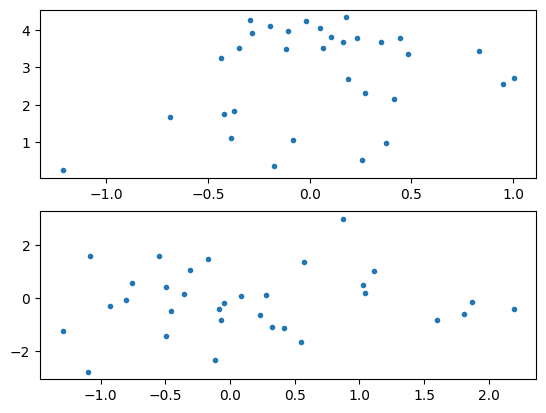

In [ ]:
plt.subplot(2,1,1)
plt.plot(xx[:,0],xx[:,1],'.')
plt.subplot(2,1,2)
plt.plot(yy[:,0],yy[:,1],'.')

In [ ]:
"""### Train and evaluate the model"""

num_epochs = 200
history = model.fit(dataset, epochs=num_epochs)

Epoch 1/200
250/250 [==============================] - 3s 4ms/step - loss: 0.9991
Epoch 2/200
250/250 [==============================] - 1s 5ms/step - loss: 1.0057
Epoch 3/200
250/250 [==============================] - 2s 6ms/step - loss: 1.0168
Epoch 4/200
250/250 [==============================] - 1s 4ms/step - loss: 0.9974
Epoch 5/200
250/250 [==============================] - 1s 4ms/step - loss: 1.0090
Epoch 6/200
236/250 [===========================>..] - ETA: 0s - loss: 0.9787

KeyboardInterrupt: ignored

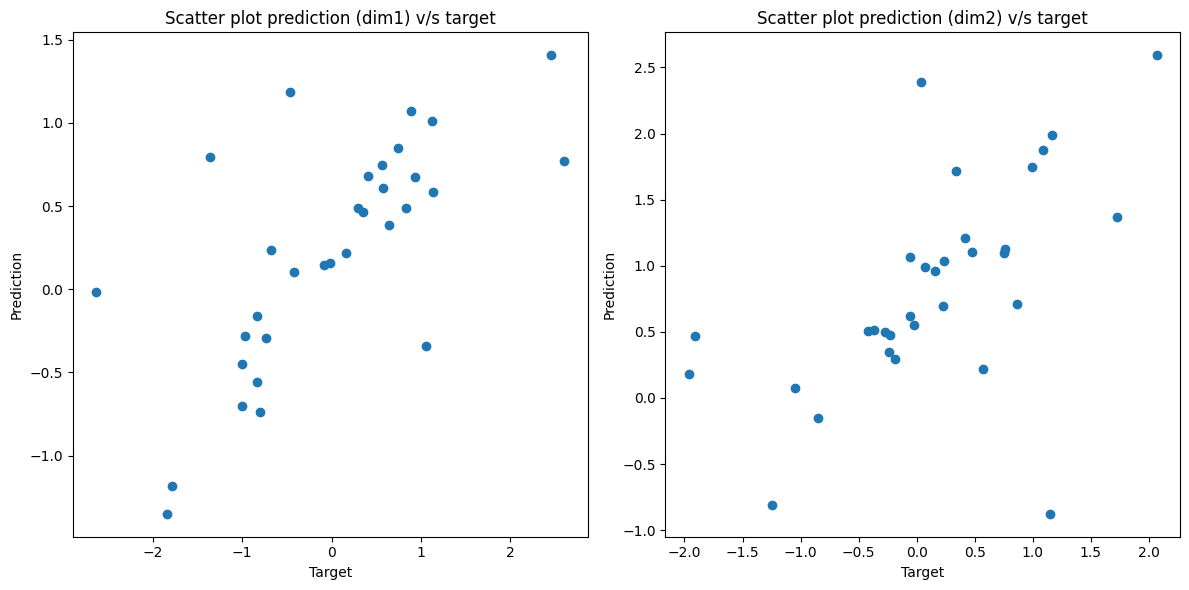

In [ ]:
"""### Scatter plots of reconstructed values v/s target

When there is a perfect match between the prediction and target, the scatter plot would be a line along y=x (45 degrees in the first quadrant). We observe similar behaviour in the plot below indicating that the model has is able to predict the target decently.
"""

#@title
# Let's check out the results
((xx, tt), yy) = next(iter(dataset))
ypred = model((xx,tt))

plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.scatter( yy[:,0], ypred[:,0])
plt.title('Scatter plot prediction (dim1) v/s target')
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.subplot(1,2,2)
plt.scatter( yy[:,1], ypred[:,1])
plt.title('Scatter plot prediction (dim2) v/s target')
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.tight_layout()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


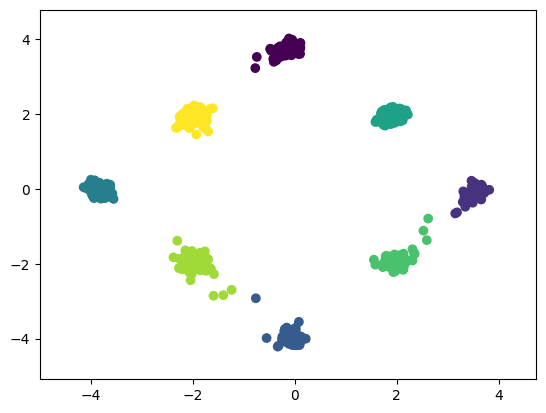

In [ ]:
"""## Reverse process of diffusion

The model provides a decent estimate of the noise given the data and t.  Now comes the tricky part: given the data at timestep t $x_t$, and the noise estimate from the model, reconstructing original data distribution.


There are 4 parts in the reverse process:
1. Pass $x_t$ and $t$ (converted to time embedding) into the model that predicts the noise $ϵ$
2. Using the noise estimate $ϵ$ and $x_t$, compute $x_0$ using equation : $\frac{1}{\sqrt{\bar{\alpha}_t}}x_t - (\sqrt{\frac{1}{\bar{\alpha}_t}-1}) \epsilon$


3. Compute mean and variance using the equations:

$\tilde{\mu}(x_t, x_0) = \frac{\sqrt{\bar{\alpha}_{t-1}} \beta_t}{1-\bar{\alpha_t}}x_0 + \frac{\sqrt{\bar{\alpha}_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t$ and
variance $\tilde{\beta}_t = \frac{(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}\beta_t$

4. Sample using this mean and variance
$q(x_{t−1}|x_t, x_0)=N(x_{t−1}; \tilde{\mu}(x_t, x_0), \tilde{\beta}_tI)$
"""

class DiffusionReconstruct(BetaDerivatives):

  def __init__(self, betas):
    super().__init__(betas)

    self.sqrt_recip_alphas_cumprod = tf.math.sqrt(1. / self.alphas_cumprod)
    self.sqrt_recipm1_alphas_cumprod = tf.math.sqrt(1. / self.alphas_cumprod - 1)

    # calculations required for posterior q(x_{t-1} | x_t, x_0)
    # Variance choice corresponds to 2nd choice mentioned in the paper
    self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)


    # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
    self.posterior_log_variance_clipped = tf.constant(np.log(np.maximum(self.posterior_variance, 1e-20)))
    self.posterior_mean_coef1 = self.betas * tf.math.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
    self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * tf.math.sqrt(self.alphas) / (1. - self.alphas_cumprod)

  def predict_start_from_noise(self, x_t, t, noise):
    """
    Reconstruct x_0 using x_t, t and noise. Uses deterministic process
    """
    return (
        self._gather(self.sqrt_recip_alphas_cumprod, t) * x_t -
        self._gather(self.sqrt_recipm1_alphas_cumprod, t) * noise
    )

  def q_posterior(self, x_start, x_t, t):
    """
    Compute the mean and variance of the diffusion posterior q(x_{t-1} | x_t, x_0)
    """
    posterior_mean = (
        self._gather(self.posterior_mean_coef1, t) * x_start +
        self._gather(self.posterior_mean_coef2, t) * x_t
    )
    posterior_log_variance_clipped = self._gather(self.posterior_log_variance_clipped, t)
    return posterior_mean, posterior_log_variance_clipped

  def p_sample(self, model, x_t, t):
    """
    Sample from the model. This does 4 things
    * Predict the noise from the model using x_t and t
    * Create estimate of x_0 using x_t and noise (reconstruction)
    * Estimate of model mean and log_variance of x_{t-1} using x_0, x_t and t
    * Sample data (for x_{t-1}) using the mean and variance values
    """
    noise_pred = model((x_t, get_timestep_embedding(t, dim_time_embeeding))) # Step 1
    x_recon = self.predict_start_from_noise(x_t, t=t, noise=noise_pred) # Step 2
    model_mean, model_log_variance = self.q_posterior(x_start=x_recon, x_t=x_t, t=t) # Step 3
    noise = noise_like(x_t.shape)
    nonzero_mask = tf.reshape(tf.cast(tf.greater(t, 0), tf.float32), (x_t.shape[0], 1))
    return model_mean + tf.exp(0.5 * model_log_variance) * noise * nonzero_mask # Step 4

  def p_sample_loop_trajectory(self, model, shape):
    """
    Generate the visualization of intermediate steps of the reverse of diffusion
    process.
    """
    times = tf.Variable([self.num_timesteps - 1], dtype=tf.int32)
    imgs = tf.Variable([noise_like(shape)])
    times, imgs = tf.while_loop(
      cond=lambda times_, _: tf.greater_equal(times_[-1], 0),
      body=lambda times_, imgs_: [
        tf.concat([times_, [times_[-1] - 1]], axis=0),
        tf.concat([imgs_, [self.p_sample(model=model,
                                         x_t=imgs_[-1],
                                         t=tf.fill([shape[0]], times_[-1]))]],
                  axis=0)
      ],
      loop_vars=[times, imgs],
      shape_invariants=[tf.TensorShape([None, 1]),
                        tf.TensorShape([None, *shape])],
      back_prop=False
    )
    return times, imgs

rec_diff = DiffusionReconstruct(betas_linear)
pred_ts, pred_data = rec_diff.p_sample_loop_trajectory(model, shape=(1000,2))

"""### Visualize the reverse process"""

final_loc = pred_data[num_diffusion_timesteps-1]
labels = []
for ptloc in final_loc:
  label = np.argmin(np.mean((ptloc - centers)**2, axis=1), axis=0)
  labels.append(label)

#@title
camera = Camera(plt.figure())

for timestep in range(0, num_diffusion_timesteps):
  plt.scatter(pred_data[timestep][:,0], pred_data[timestep][:,1], c=labels)
  camera.snap()

save_animation('outcomes.mp4')

"""In the below video, we show the reconstruction process of the data from noise. We start with 1000 samples  from std. normal distribution (gaussian noise) and iteratively move towards the original data distribution using the model trained above.

As you can see towards the end of the video below, the noise maps back to the original data distribution.
"""

show_video('outcomes.mp4')